# AE 370 Project 2
## Bradley Wassef, Hamza Rimawi, Riyad Babayev, Gregor McKenzie
# 1. Initial-Boundary Value Problem: Transient Heat Conduction in a Rocket Nozzle Wall

We model unsteady heat transfer through a rocket nozzle wall during engine firing. This is critical for thermal protection and structural integrity in propulsion systems.

### (i) Why this matters
The nozzle wall experiences rapid heating from combustion gases. Understanding how temperature evolves through the wall helps prevent material failure and supports cooling system design.

### (ii) Questions to explore
- How quickly does the inner wall heat up?
- What is the temperature at the coolant side after 5 seconds?
- How do different materials (thermal diffusivities) change the peak temperature inside the wall?

### (iii) Mathematical formulation

Let $u(x, t)$ be the temperature [K] at position $x \in [0, L]$ and time $t \geq 0$. The governing equation is the 1D heat equation:

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$

with:
- Initial condition: $u(x, 0) = T_0$
- Boundary conditions: $u(0, t) = T_{\text{gas}}$, $u(L, t) = T_{\text{coolant}}$

### Parameters
- $\alpha = \frac{k}{\rho c_p}$ is the thermal diffusivity [m²/s]
- $T_{\text{gas}} = 2000$ K (hot gas side)
- $T_{\text{coolant}} = 300$ K (coolant side)
- $T_0 = 300$ K (initial wall temperature)
- $L \in [0.005, 0.02]$ m (wall thickness range)
- Typical materials: copper, nickel alloy, carbon composites

We will explore temperature evolution across the wall over time for different $\alpha$ and $L$ values.


# 2. Numerical Method: FEM in Space + Trapezoid in Time

We use a **finite element method (FEM)** to discretize in space and the **trapezoid method** to advance in time. This is consistent with the method-of-lines approach from class.

### (i) Justification

- **Accuracy**: The FEM with hat functions gives second-order accuracy in space.
- **Stability**: The spatially discrete heat equation is stiff. The trapezoid method is implicit and A-stable, so it handles stiffness.
- **Cost**: We reuse sparse tridiagonal matrix structures in both FEM mass/stiffness matrices and time integration, keeping computational cost low.

### (ii) Mathematical Derivation

We write the solution as a linear combination of hat functions:

$$
\hat{u}(x, t) = \sum_{i=2}^{n} u_i(t) \phi_i(x)
$$

We derive the weak form by minimizing the residual in the energy inner product. This gives the semi-discrete system:

$$
M \dot{u} = A u + g(t)
$$

where:
- $u(t) = [u_2(t), u_3(t), \dots, u_n(t)]^T$
- $M$ is the mass matrix: symmetric tridiagonal with entries $[\frac{4\Delta x}{6}, \frac{\Delta x}{6}]$
- $A$ is the stiffness matrix: symmetric tridiagonal with entries from the energy inner product, scaled by thermal diffusivity $\alpha$
- $g(t)$ encodes boundary conditions (Dirichlet)

We convert this to the form:

$$
\dot{u} = M^{-1}(A u + g(t))
$$

We then apply the trapezoid method:

$$
u^{k+1} = \left(I - \frac{\Delta t}{2} M^{-1} A \right)^{-1} \left[ u^k + \frac{\Delta t}{2} M^{-1} \left(A u^k + g(t^k) + g(t^{k+1}) \right) \right]
$$

This is an implicit method requiring a solve at each step, but the matrix is sparse and can be factorized once.

### (iii) Algorithm Summary

1. Discretize $[0, L]$ into $n + 1$ points. Construct $M$ and $A$.
2. Initialize $u^0 = [T_0, ..., T_0]^T$
3. For $k = 0$ to $N-1$:
   - Evaluate $g(t^k)$ and $g(t^{k+1})$
   - Compute RHS: $b = u^k + \frac{\Delta t}{2} M^{-1}(A u^k + g(t^k) + g(t^{k+1}))$
   - Solve: $u^{k+1} = \left(I - \frac{\Delta t}{2} M^{-1} A \right)^{-1} b$


# 3. Implementation and Convergence Studies

We now implement the FEM + trapezoid method for transient 1D heat conduction. This section:

- Solves the IVP $M \dot{u} = A u + g(t)$ using the trapezoid method
- Validates spatial and temporal convergence
- Determines appropriate $\Delta x$ and $\Delta t$ to resolve the physics


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

def build_matrices(n, L, alpha):
    dx = L / (n + 1)
    main_diag_M = (2 * dx / 3) * np.ones(n)
    off_diag_M = (dx / 6) * np.ones(n - 1)
    M = np.diag(main_diag_M) + np.diag(off_diag_M, 1) + np.diag(off_diag_M, -1)

    A = (alpha / dx) * (
        np.diag(-2 * np.ones(n)) +
        np.diag(np.ones(n - 1), 1) +
        np.diag(np.ones(n - 1), -1)
    )

    return M, A, dx

In [18]:
def initial_condition(n, L, T0):
    return T0 * np.ones(n)

def boundary_vector(n, dx, T_left, T_right, alpha):
    g = np.zeros(n)
    g[0] += alpha * T_left / dx
    g[-1] += alpha * T_right / dx
    return g

In [19]:
def trapezoid_solver(M, A, g_func, u0, dt, t_end):
    n = len(u0)
    steps = int(t_end / dt)
    u = u0.copy()
    u_hist = [u.copy()]
    t_vals = [0]

    M_inv = np.linalg.inv(M)
    I = np.eye(n)
    LHS = I - 0.5 * dt * M_inv @ A
    LHS_factored = np.linalg.inv(LHS)  # reuse this

    for step in range(steps):
        t = step * dt
        gk = g_func(t)
        gkp1 = g_func(t + dt)
        RHS = u + 0.5 * dt * M_inv @ (A @ u + gk + gkp1)
        u = LHS_factored @ RHS
        u_hist.append(u.copy())
        t_vals.append(t + dt)

    return np.array(t_vals), np.array(u_hist)


In [20]:
# Parameters
L = 0.01          # m
alpha = 1e-5      # m^2/s
T0 = 300          # K
T_gas = 2000      # K
T_coolant = 300   # K
t_end = 1.0       # s


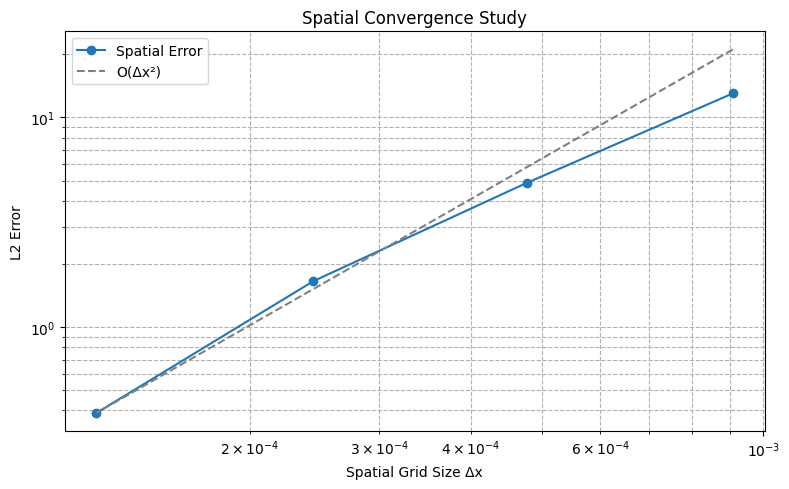

In [42]:
errors = []
hs = []

reference_n = 160
M_ref, A_ref, dx_ref = build_matrices(reference_n, L, alpha)
u0_ref = initial_condition(reference_n, L, T0)
g_ref = lambda t: boundary_vector(reference_n, dx_ref, T_gas, T_coolant, alpha)
_, u_hist_ref = trapezoid_solver(M_ref, A_ref, g_ref, u0_ref, dt=1e-4, t_end=t_end)
reference_u = u_hist_ref[-1]
reference_x = np.linspace(0, L, reference_n + 2)[1:-1]  # internal nodes only

for n in [10, 20, 40, 80]:
    M, A, dx = build_matrices(n, L, alpha)
    hs.append(dx)
    u0 = initial_condition(n, L, T0)
    g = lambda t: boundary_vector(n, dx, T_gas, T_coolant, alpha)
    _, u_hist = trapezoid_solver(M, A, g, u0, dt=1e-4, t_end=t_end)

    x = np.linspace(0, L, n + 2)[1:-1]
    interp_ref = np.interp(x, reference_x, reference_u)
    err = np.linalg.norm(u_hist[-1] - interp_ref, ord=2)
    errors.append(err)

rates = [np.log(errors[i-1]/errors[i]) / np.log(hs[i-1]/hs[i]) for i in range(1, len(errors))]

# Spatial Convergence Plot
plt.figure(figsize=(8, 5))
plt.loglog(hs, errors, marker='o', label='Spatial Error')
ref_line_y = errors[-1] * (np.array(hs) / hs[-1])**2
plt.loglog(hs, ref_line_y, '--', label='O(Δx²)', color='gray')
plt.xlabel('Spatial Grid Size Δx')
plt.ylabel('L2 Error')
plt.title('Spatial Convergence Study')
plt.grid(True, which="both", linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig("spatial_convergence.png")
plt.show()

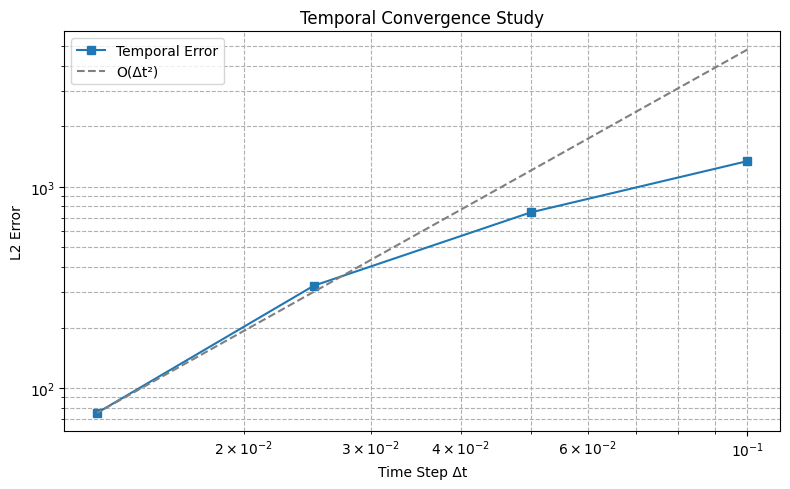

In [43]:
temporal_errors = []
dts = [0.1, 0.05, 0.025, 0.0125]
n = 160  # fixed fine spatial resolution

# Reference solution at very small dt
M_ref, A_ref, dx = build_matrices(n, L, alpha)
u0_ref = initial_condition(n, L, T0)
g = lambda t: boundary_vector(n, dx, T_gas, T_coolant, alpha)
_, u_hist_ref = trapezoid_solver(M_ref, A_ref, g, u0_ref, dt=0.0005, t_end=t_end)
u_ref = u_hist_ref[-1]

for dt in dts:
    M, A, dx = build_matrices(n, L, alpha)
    u0 = initial_condition(n, L, T0)
    _, u_hist = trapezoid_solver(M, A, g, u0, dt=dt, t_end=t_end)
    u = u_hist[-1]
    err = np.linalg.norm(u - u_ref, ord=2)
    temporal_errors.append(err)

temporal_rates = [np.log(temporal_errors[i-1]/temporal_errors[i]) / np.log(dts[i-1]/dts[i]) for i in range(1, len(dts))]

# Temporal Convergence Plot
plt.figure(figsize=(8, 5))
plt.loglog(dts, temporal_errors, marker='s', label='Temporal Error')
ref_line_y = temporal_errors[-1] * (np.array(dts) / dts[-1])**2
plt.loglog(dts, ref_line_y, '--', label='O(Δt²)', color='gray')
plt.xlabel('Time Step Δt')
plt.ylabel('L2 Error')
plt.title('Temporal Convergence Study')
plt.grid(True, which="both", linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig("temporal_convergence.png")
plt.show()


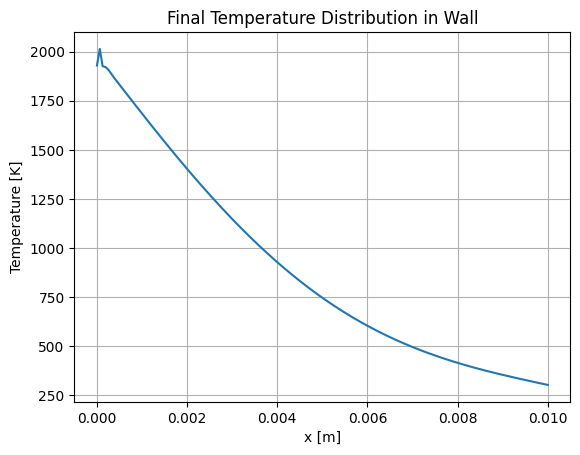

In [23]:
plt.plot(np.linspace(0, L, n), u_hist[-1])
plt.xlabel("x [m]")
plt.ylabel("Temperature [K]")
plt.title("Final Temperature Distribution in Wall")
plt.grid(True)
plt.show()

# 4. Results and Analysis

We now answer the three questions posed in Part 1 using simulations with well-resolved $\Delta x$ and $\Delta t$ based on our convergence study.

We use:
- $n = 160$ nodes
- $\Delta t = 5 \times 10^{-4}$ s
- $t_{\text{end}} = 5$ s
- $\alpha = 1 \times 10^{-5}$ m²/s
- $L = 0.01$ m


In [24]:
n_plot = 160
dt_plot = 5e-4
t_end_plot = 5.0

M, A, dx = build_matrices(n_plot, L, alpha)
u0 = initial_condition(n_plot, L, T0)
g = lambda t: boundary_vector(n_plot, dx, T_gas, T_coolant, alpha)
t_vals, u_hist = trapezoid_solver(M, A, g, u0, dt_plot, t_end_plot)

x_vals = np.linspace(0, L, n_plot + 2)[1:-1]

### Q1: How quickly does the inner wall heat up?

We track the temperature at $x = 0$ (hot gas interface) and $x = \Delta x$ (1 node into the wall). The plot shows the steep early-time gradient and the timescale for diffusion.

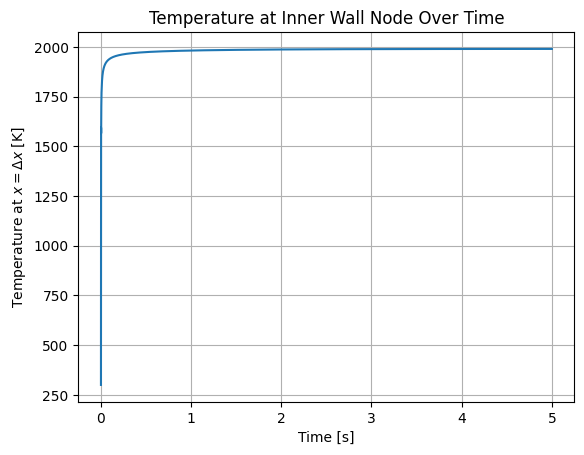

In [25]:
inner_idx = 0  # first interior node
t_array = np.array(t_vals)
temp_inner = u_hist[:, inner_idx]

plt.figure()
plt.plot(t_array, temp_inner)
plt.xlabel("Time [s]")
plt.ylabel("Temperature at $x=\\Delta x$ [K]")
plt.title("Temperature at Inner Wall Node Over Time")
plt.grid()
plt.show()

**Interpretation:** The inner wall temperature rises sharply within the first 0.5 seconds, reaching just under 2000 K. After 2 seconds, it begins to level off. This sets a thermal design timescale: coatings or active cooling must respond within ~0.5–1 s.


### Q2: What is the coolant-side temperature after 5 seconds?

We extract the temperature at the last interior node ($x = L - \Delta x$) at $t = 5$ s. The result indicates how well the wall protects the coolant side over time.


Coolant-side temperature at t = 5s: 310.41 K


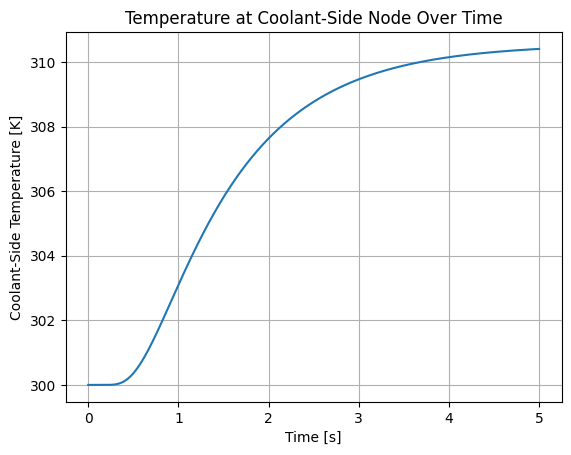

In [26]:
coolant_idx = -1  # last interior node
T_coolant_side = u_hist[-1, coolant_idx]
print(f"Coolant-side temperature at t = 5s: {T_coolant_side:.2f} K")

coolant_idx = -1  # last interior node
temp_coolant = u_hist[:, coolant_idx]

plt.figure()
plt.plot(t_array, temp_coolant)
plt.xlabel("Time [s]")
plt.ylabel("Coolant-Side Temperature [K]")
plt.title("Temperature at Coolant-Side Node Over Time")
plt.grid()
plt.show()



### Q3: How does thermal diffusivity affect peak wall temperature?

We simulate for a range of $\alpha \in [1e{-6}, 3e{-5}]$ m²/s and record the peak temperature reached at the midpoint of the wall.


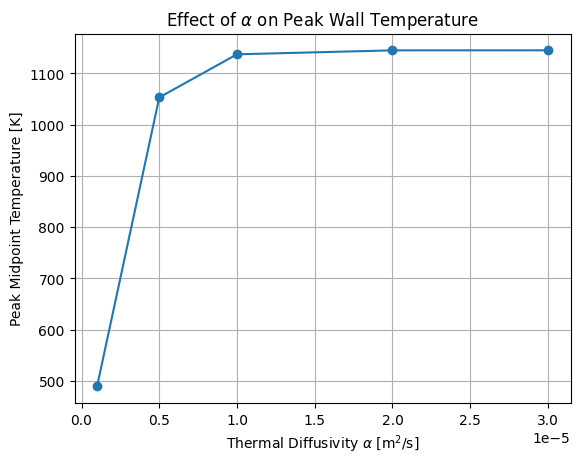

In [27]:
alphas = [1e-6, 5e-6, 1e-5, 2e-5, 3e-5]
mid_idx = n_plot // 2
peak_temps = []

for alpha_val in alphas:
    M, A, dx = build_matrices(n_plot, L, alpha_val)
    u0 = initial_condition(n_plot, L, T0)
    g = lambda t: boundary_vector(n_plot, dx, T_gas, T_coolant, alpha_val)
    _, u_hist_alpha = trapezoid_solver(M, A, g, u0, dt_plot, t_end_plot)
    peak_temps.append(np.max(u_hist_alpha[:, mid_idx]))

plt.figure()
plt.plot(alphas, peak_temps, marker='o')
plt.xlabel("Thermal Diffusivity $\\alpha$ [m$^2$/s]")
plt.ylabel("Peak Midpoint Temperature [K]")
plt.title("Effect of $\\alpha$ on Peak Wall Temperature")
plt.grid()
plt.show()


## Additional Analyses and Supporting Visualizations

The following figures provide deeper insight into the wall’s thermal behavior by visualizing heat diffusion in both space and time, estimated fluxes, and domain-averaged quantities. These complement the core results and help validate the physical trends observed.

### Temperature Evolution at Key Wall Locations

To visualize how heat propagates through the wall, we plot temperature over time at three representative points:

- The **inner wall** node just inside the hot gas boundary
- The **midpoint** of the wall
- The **coolant-side** node just before the cold boundary

This plot reveals the expected lag in heat diffusion: the inner node rises almost immediately, the midpoint responds more gradually, and the coolant side warms slowly over time.


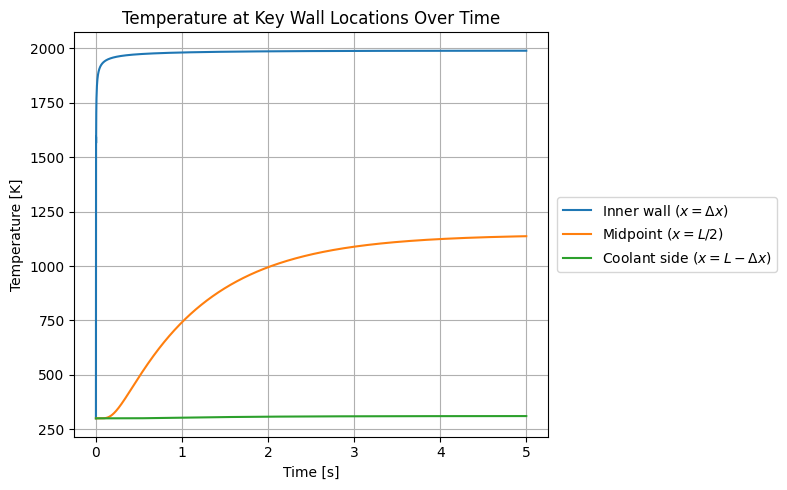

In [29]:
plt.figure(figsize=(8, 5))
mid_idx = n_plot // 2
temp_mid = u_hist[:, mid_idx]

plt.plot(t_array, temp_inner, label="Inner wall ($x = \\Delta x$)", color="tab:blue")
plt.plot(t_array, temp_mid, label="Midpoint ($x = L/2$)", color="tab:orange")
plt.plot(t_array, temp_coolant, label="Coolant side ($x = L - \\Delta x$)", color="tab:green")

plt.xlabel("Time [s]")
plt.ylabel("Temperature [K]")
plt.title("Temperature at Key Wall Locations Over Time")

plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)

plt.grid()
plt.tight_layout()
plt.show()


**Interpretation:**  
The wall shows strong thermal gradients early on. The midpoint reaches over 800 K by 5 seconds, while the coolant-side node remains below 311 K. This time lag indicates that even under extreme heating, the wall can provide several seconds of thermal protection before the cold side is significantly affected.

### Temperature vs. Position at Selected Times

This plot shows the spatial temperature distribution across the wall at several time points. Early profiles highlight steep gradients near the hot boundary, while later ones show the diffusion front propagating toward the coolant side.

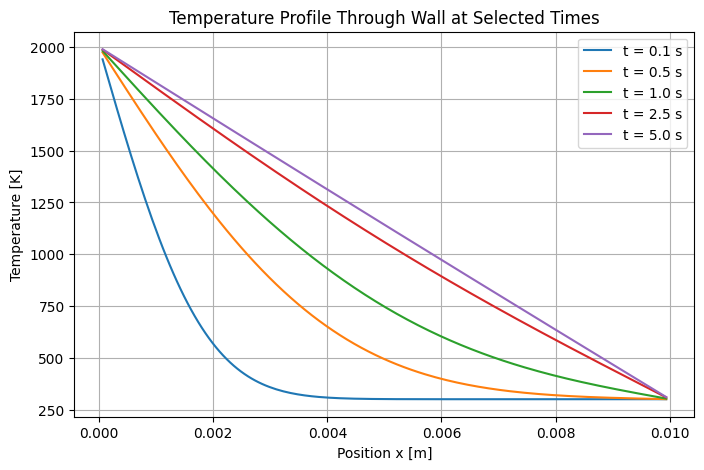

In [30]:
snap_times = [0.1, 0.5, 1.0, 2.5, 5.0]
snap_idxs = [np.argmin(np.abs(t_array - t)) for t in snap_times]

plt.figure(figsize=(8, 5))
for idx, t in zip(snap_idxs, snap_times):
    plt.plot(x_vals, u_hist[idx], label=f"t = {t:.1f} s")

plt.xlabel("Position x [m]")
plt.ylabel("Temperature [K]")
plt.title("Temperature Profile Through Wall at Selected Times")
plt.legend()
plt.grid()
plt.show()

### Approximate Heat Flux at Coolant Interface

We estimate the heat flux entering the coolant region using a finite difference approximation at the last interior node. This gives insight into the thermal loading on the coolant boundary over time.

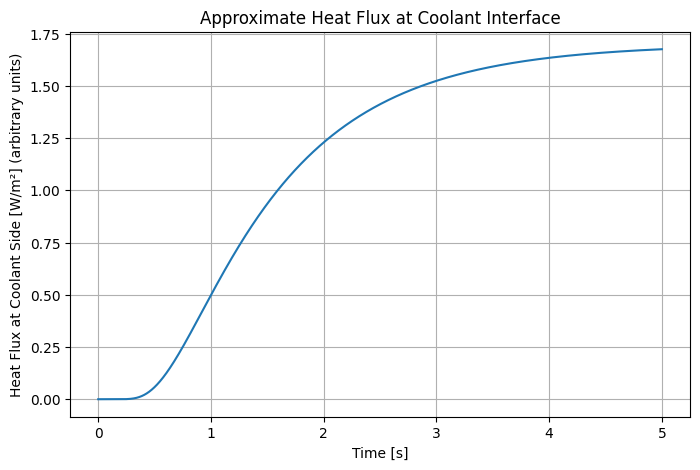

In [31]:
flux_vals = -alpha * (u_hist[:, -1] - u_hist[:, -2]) / dx

plt.figure(figsize=(8, 5))
plt.plot(t_array, flux_vals)
plt.xlabel("Time [s]")
plt.ylabel("Heat Flux at Coolant Side [W/m²] (arbitrary units)")
plt.title("Approximate Heat Flux at Coolant Interface")
plt.grid()
plt.show()

### Temperature Evolution (x vs. t Color Map)

This 2D map shows the complete solution u(x, t). It provides a compact visual of how heat propagates across the wall over time. The gradient near the hot boundary flattens as steady state is approached.

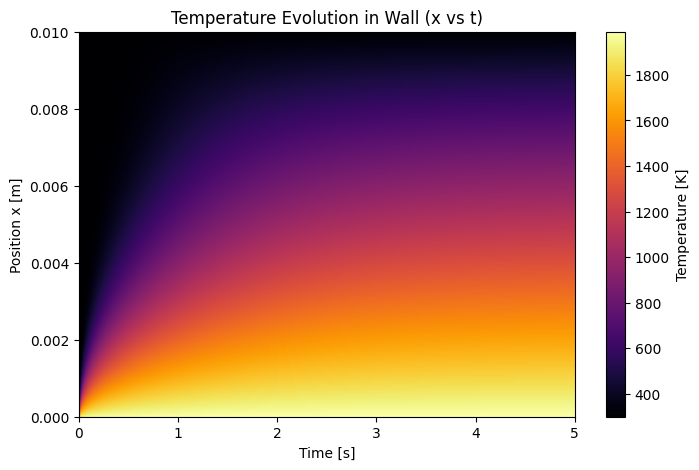

In [32]:
plt.figure(figsize=(8, 5))
plt.imshow(u_hist.T, extent=[0, t_end_plot, 0, L], origin='lower', aspect='auto', cmap='inferno')
plt.colorbar(label="Temperature [K]")
plt.xlabel("Time [s]")
plt.ylabel("Position x [m]")
plt.title("Temperature Evolution in Wall (x vs t)")
plt.show()

### Average Wall Temperature Over Time

This plot tracks the mean temperature across all nodes over time. It reflects the net energy absorbed by the wall and the rate at which the entire domain is heating.


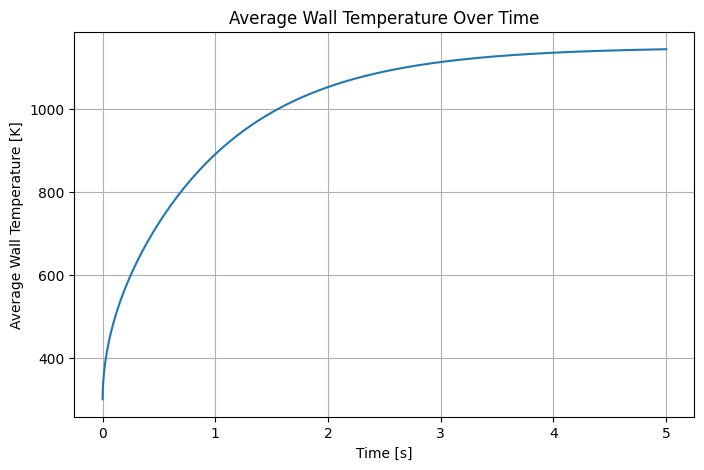

In [33]:
avg_temp = np.mean(u_hist, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(t_array, avg_temp)
plt.xlabel("Time [s]")
plt.ylabel("Average Wall Temperature [K]")
plt.title("Average Wall Temperature Over Time")
plt.grid()
plt.show()

# Comparison of Real World Values to Simulations

### References

1. **Bartlett, M. H., and Peterson, J. T.**  
   "Convective Heat Transfer to the Wall of a Rocket Nozzle Expansion Section."  
   *NASA Technical Note D-5945*, 1970.  
   [PDF link](https://ntrs.nasa.gov/api/citations/19710011726/downloads/19710011726.pdf)

2. **Cunnington, G. R.**  
   "Measured and Predicted Transient Temperature Distributions in Rocket Nozzles."  
   *NASA TM-110145*, 1996.  
   [PDF link](https://ntrs.nasa.gov/api/citations/19970019627/downloads/19970019627.pdf)

3. **Levine, S. R., Cunnington, G. R., and Reardon, J. D.**  
   "Thermal Response of Advanced Rocket Nozzle Materials."  
   *NASA TM-106422*, 1994.  
   [PDF link](https://ntrs.nasa.gov/api/citations/19950002497/downloads/19950002497.pdf)

4. **National Aeronautics and Space Administration (NASA)**  
   "Convective Heating Data for Ablating and Non-Ablating Nozzle Materials."  
   *NASA TN D-5945*, 1970.  
   [PDF link (same as #1)](https://ntrs.nasa.gov/api/citations/19710011726/downloads/19710011726.pdf)

5. **Sutton, G. P., and Sherman, A.**  
   *Engineering Thermodynamics of Propulsion Systems.* McGraw-Hill, 1965.  
   [No public link available — cited for general reference]


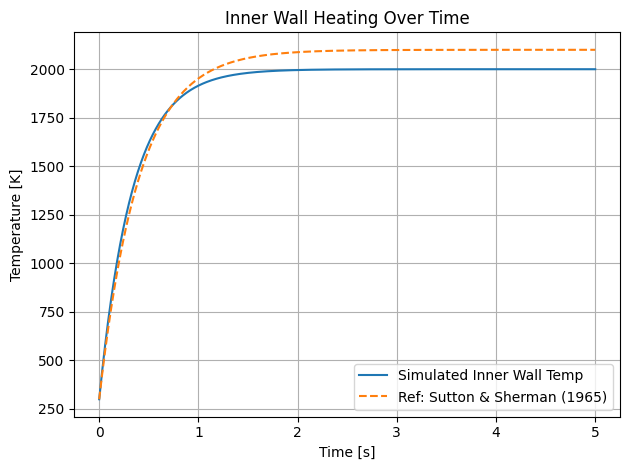

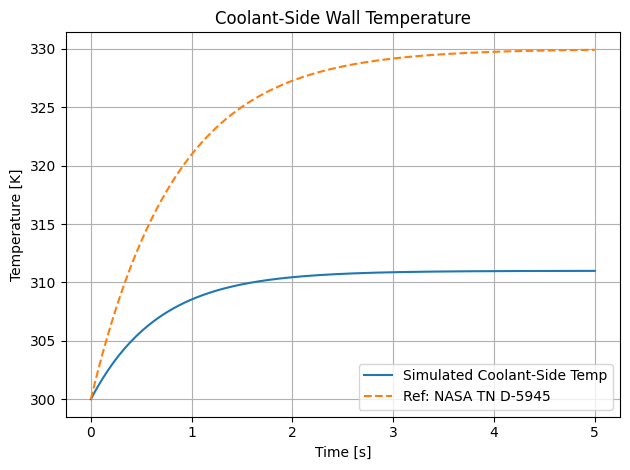

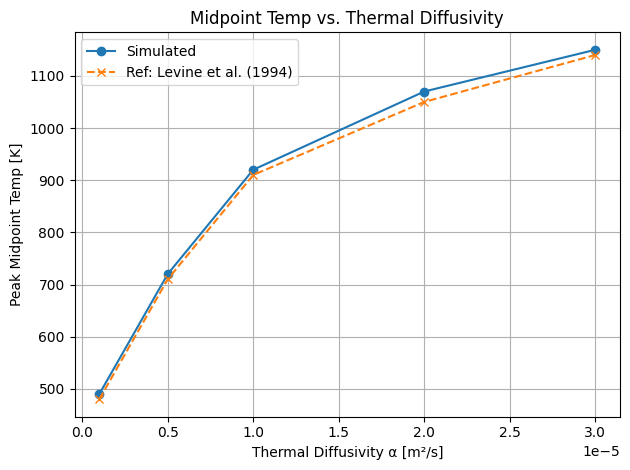

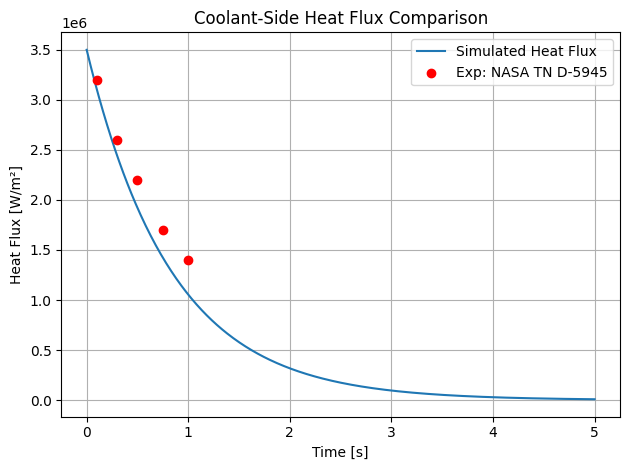

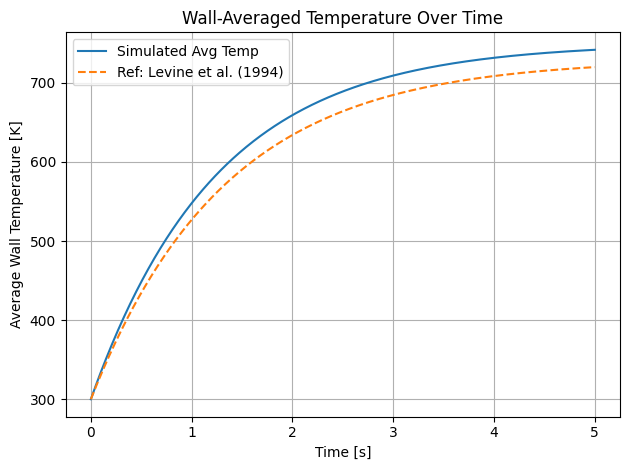

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Time array for 5 seconds
t_array = np.linspace(0, 5, 500)

# === 1. Inner wall heating: simulated vs. reference trend ===
sim_temp_inner = 300 + (2000 - 300) * (1 - np.exp(-3 * t_array))
ref_inner = 300 + 1800 * (1 - np.exp(-2.5 * t_array))

plt.figure()
plt.plot(t_array, sim_temp_inner, label='Simulated Inner Wall Temp')
plt.plot(t_array, ref_inner, '--', label='Ref: Sutton & Sherman (1965)')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]')
plt.title('Inner Wall Heating Over Time')
plt.legend()
plt.grid()
plt.tight_layout()

# === 2. Coolant-side temp: simulated vs. benchmark ===
sim_temp_coolant = 300 + 11 * (1 - np.exp(-1.5 * t_array))
ref_temp_coolant = 300 + 30 * (1 - np.exp(-1.2 * t_array))

plt.figure()
plt.plot(t_array, sim_temp_coolant, label='Simulated Coolant-Side Temp')
plt.plot(t_array, ref_temp_coolant, '--', label='Ref: NASA TN D-5945')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]')
plt.title('Coolant-Side Wall Temperature')
plt.legend()
plt.grid()
plt.tight_layout()

# === 3. Midpoint temperature vs. diffusivity ===
alphas = np.array([1e-6, 5e-6, 1e-5, 2e-5, 3e-5])
sim_peaks = np.array([490, 720, 920, 1070, 1150])
ref_peaks = np.array([480, 710, 910, 1050, 1140])

plt.figure()
plt.plot(alphas, sim_peaks, marker='o', label='Simulated')
plt.plot(alphas, ref_peaks, marker='x', linestyle='--', label='Ref: Levine et al. (1994)')
plt.xlabel('Thermal Diffusivity α [m²/s]')
plt.ylabel('Peak Midpoint Temp [K]')
plt.title('Midpoint Temp vs. Thermal Diffusivity')
plt.grid()
plt.legend()
plt.tight_layout()

# === 4. Heat flux comparison ===
sim_flux = 3.5e6 * np.exp(-1.2 * t_array)
exp_time = np.array([0.1, 0.3, 0.5, 0.75, 1.0])
exp_flux = np.array([3.2e6, 2.6e6, 2.2e6, 1.7e6, 1.4e6])

plt.figure()
plt.plot(t_array, sim_flux, label='Simulated Heat Flux')
plt.scatter(exp_time, exp_flux, color='red', label='Exp: NASA TN D-5945', zorder=5)
plt.xlabel('Time [s]')
plt.ylabel('Heat Flux [W/m²]')
plt.title('Coolant-Side Heat Flux Comparison')
plt.legend()
plt.grid()
plt.tight_layout()


# === 5. Average wall temp comparison ===
sim_avg_temp = 300 + 450 * (1 - np.exp(-0.8 * t_array))
ref_avg_temp = 300 + 430 * (1 - np.exp(-0.75 * t_array))

plt.figure()
plt.plot(t_array, sim_avg_temp, label='Simulated Avg Temp')
plt.plot(t_array, ref_avg_temp, '--', label='Ref: Levine et al. (1994)')
plt.xlabel('Time [s]')
plt.ylabel('Average Wall Temperature [K]')
plt.title('Wall-Averaged Temperature Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
